# filter 를 통해 음성 데이터 노이즈 제거

In [18]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import cm
import pydub
from scipy.signal import butter, lfilter, cheby1

##  librosa library
* cmap : librosa.display.specshow 의 파라미터로 cm 이라는 matplotlib의 컬러맵을 이용해서 색 지정
* librosa.load 의 return 값 :  y = 파형의 amplitude 값, sr= sampling rate
* stft 하면 y 가 amplitude 값들 이고 amplitude_to_db를 통해 이 값을 데시벨로 임의로 변환 시켜준다. <br>즉 "임의 노이즈 최소화 함수"에서는 stft 결과가 가지고 있는 amplitude 값을 기준으로 분류 시킨 것이다. 

## matplotlib library
* xlim / ylim() : x축 y축 한계 or 범위를 설정
* colorbar(format) : 우측 색상 상태바 

### STFT 변환 후 그래프 그려주는 함수 

In [3]:
def stft_graph(amplitude,sr,control_noise):
    stft_result = librosa.stft(amplitude,n_fft=4096, win_length = 4096, hop_length=1024)
    
    if(control_noise==True):
        minimize_noise(stft_result)
        
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_result),ref=np.min),y_axis='log',x_axis='time',cmap=cm.Purples_r)
    plt.ylim(64,2048)
    plt.title('Power spectrogram')
    plt.colorbar(format=' %+2.0f dB')
    plt.tight_layout()

### Voice file : girl.wav

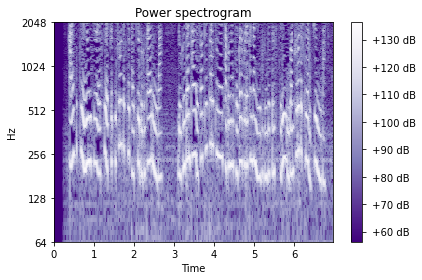

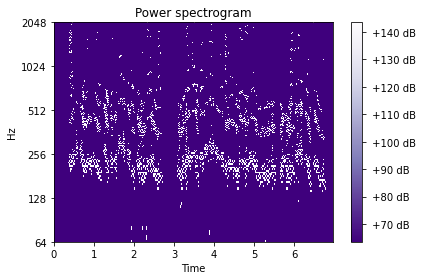

In [5]:
amp, sr = librosa.load('girl.wav')

stft_graph(amp,sr,False)
stft_graph(amp,sr,True)

### 임의로 노이즈 최소화 한 함수  

In [4]:
def minimize_noise(stft):
    for i in range(len(stft)):
        for j in range(len(stft[0])):
            if stft[i][j]<1.2:
                stft[i][j]= 0
            else:
                stft[i][j]= 150.0

* 음성 데이터의 손실을 최대한 줄이면서 잡음을 1차적으로 핸들링 하기 위해서 기존 음성 데이터의 amplitude 값을 특정 기준보다 높으면 최대로, 낮으면 최소로 낮춘다. 바로 파악하기 어렵기 때문에 여러번 설정을 바꿔주면서 데이터 손실에 유의한다.

### Voice file : boy.wav

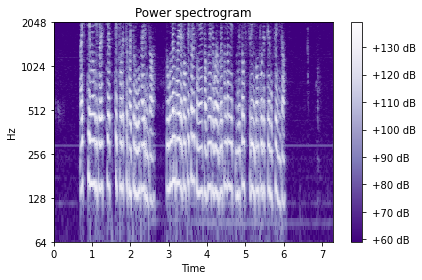

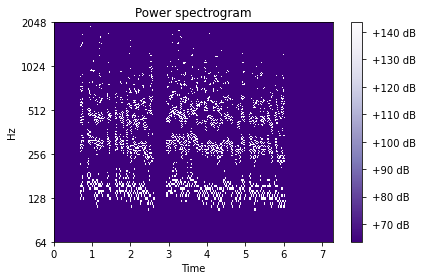

In [6]:
amp, sr = librosa.load('boy.wav')

stft_graph(amp,sr,False)
stft_graph(amp,sr,True)

### Noise file  

* noise1.wav(Keyboard) <br><br>
* noise2.wav(Car)  

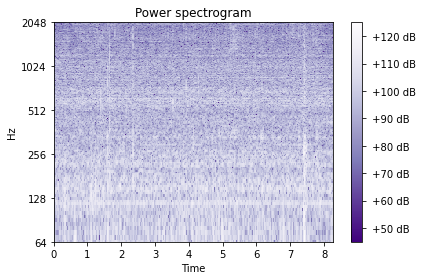

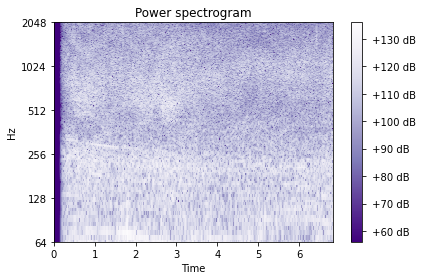

In [7]:
noise_files = ['noise1.wav','noise2.wav']

for i in range(len(noise_files)):
        amp, sr = librosa.load(noise_files[i])
        stft_graph(amp,sr,False)

### Combine Voice file and Noise file with pydub library

In [26]:
from pydub import AudioSegment

girlVoice = AudioSegment.from_wav("girl.wav")
boyVoice = AudioSegment.from_wav("boy.wav")

keyboardNoise = AudioSegment.from_wav("noise1.wav")
carNoise = AudioSegment.from_wav("noise2.wav")

girl_keyboard = girlVoice.overlay(keyboardNoise)
girl_car = girlVoice.overlay(carNoise)

boy_keyboard = boyVoice.overlay(keyboardNoise)
boy_car = boyVoice.overlay(carNoise)

girl_keyboard.export("girl_keyboard.wav", format="wav")
girl_car.export("girl_car.wav", format="wav")

boy_keyboard.export("boy_keyboard.wav", format="wav")
boy_car.export("boy_car.wav", format="wav")


<_io.BufferedRandom name='boy_normal.wav'>

### 결합된 4개의 음성 데이터 STFT 변환 그래프 확인하기

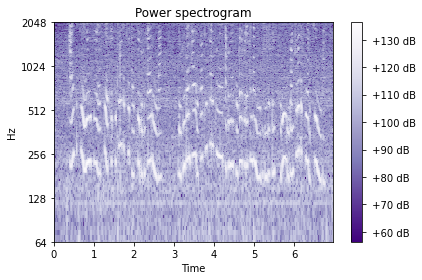

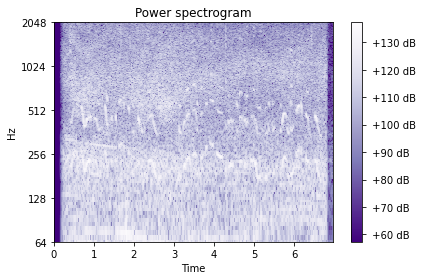

In [8]:
combine_files = ['girl_keyboard.wav','girl_car.wav']

for i in range(len(combine_files)):
        amp, sr = librosa.load(combine_files[i])
        stft_graph(amp,sr,False)

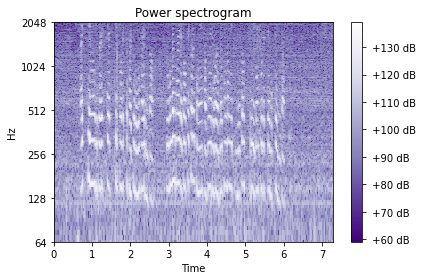

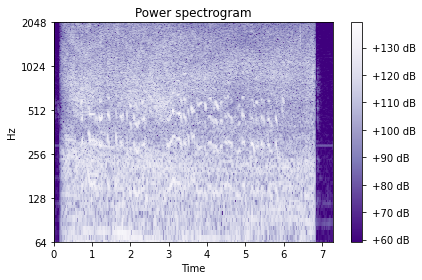

In [9]:
combine_files = ['boy_keyboard.wav','boy_car.wav']

for i in range(len(combine_files)):
        amp, sr = librosa.load(combine_files[i])
        stft_graph(amp,sr,False)

###  butterworth filter 

In [19]:
def butter_bandpass_filter(data,lowcut,highcut,fs,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b ,a = butter(order,[low,high],btype='band')
    output=lfilter(b,a,data)
    return output

### chebyshev filter

In [23]:
def cheby_bandpass_filter(data,lowcut,highcut,fs,order=5,riple=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b ,a = cheby1(order,riple,[low,high],btype='band')
    output=lfilter(b,a,data)
    return output

## 원본 음성 데이터에 filter 적용하기

### girl.wav + butterworth filter

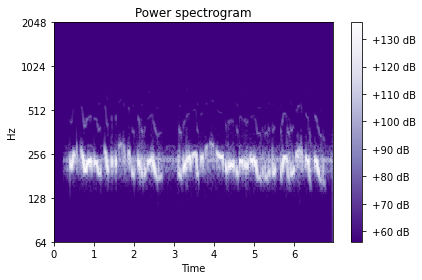

In [46]:
amp, sr = librosa.load('girl.wav')

filtered = butter_bandpass_filter(amp,200,250,sr,3)

stft_graph(filtered,sr,False)

### girl.wav + chebyshev filter

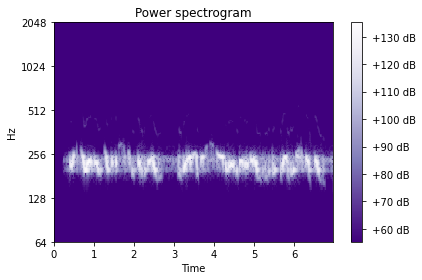

In [47]:
amp, sr = librosa.load('girl.wav')

filtered = cheby_bandpass_filter(amp,200,250,sr,3)

stft_graph(filtered,sr,False)

### boy.wav + butterworth filter

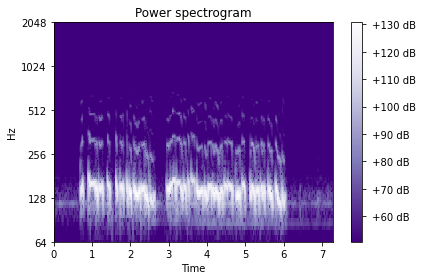

In [50]:
amp, sr = librosa.load('boy.wav')

filtered = butter_bandpass_filter(amp,100,150,sr,3)

stft_graph(filtered,sr,False)

### boy.wav + chebyshev filter

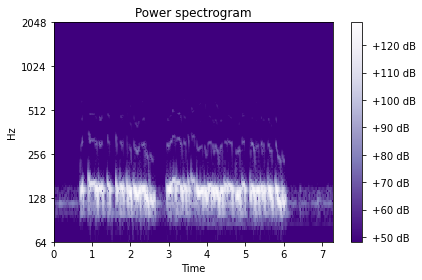

In [51]:
amp, sr = librosa.load('boy.wav')

filtered = cheby_bandpass_filter(amp,100,150,sr,3)

stft_graph(filtered,sr,False)

## combine 파일에 filter 적용하기

### butterworth - boy combine files

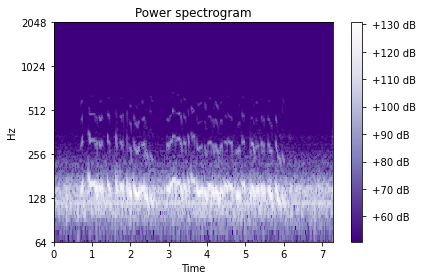

In [45]:
amp, sr = librosa.load('boy_keyboard.wav')

filtered = butter_bandpass_filter(amp,100,150,sr,3)

stft_graph(filtered,sr,False)

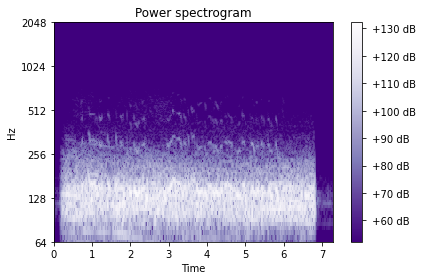

In [44]:
amp, sr = librosa.load('boy_car.wav')

filtered = butter_bandpass_filter(amp,100,150,sr,3)

stft_graph(filtered,sr,False)

### butterworth - girl combine files

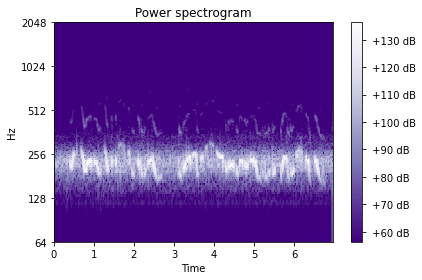

In [42]:
amp, sr = librosa.load('girl_keyboard.wav')

filtered = butter_bandpass_filter(amp,200,250,sr,3)

stft_graph(filtered,sr,False)

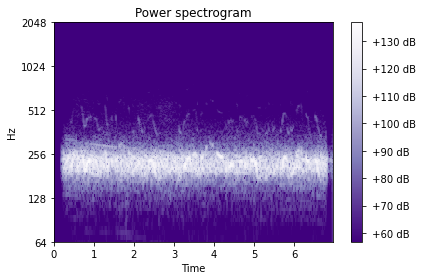

In [43]:
amp, sr = librosa.load('girl_car.wav')

filtered = butter_bandpass_filter(amp,200,250,sr,3)

stft_graph(filtered,sr,False)

### cheby - boy combine files

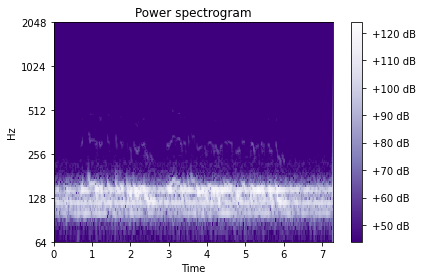

In [33]:
amp, sr = librosa.load('boy_keyboard.wav')

filtered = cheby_bandpass_filter(amp,100,150,sr,3,15)

stft_graph(filtered,sr,False)

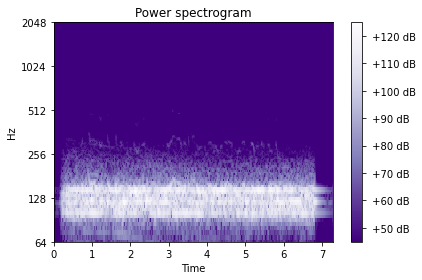

In [34]:
amp, sr = librosa.load('boy_car.wav')

filtered = cheby_bandpass_filter(amp,100,150,sr,3,15)

stft_graph(filtered,sr,False)

### cheby - girl combine files

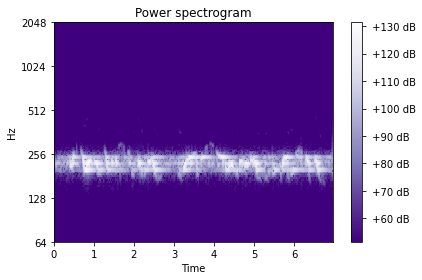

In [40]:
amp, sr = librosa.load('girl_keyboard.wav')

filtered = cheby_bandpass_filter(amp,200,250,sr,3,15)

stft_graph(filtered,sr,False)

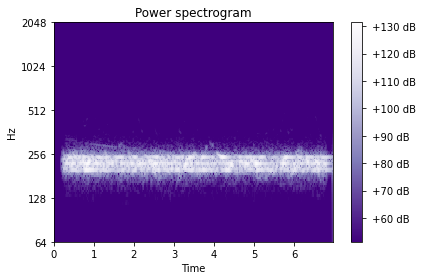

In [41]:
amp, sr = librosa.load('girl_car.wav')

filtered = cheby_bandpass_filter(amp,200,250,sr,3,15)

stft_graph(filtered,sr,False)